<a href="https://colab.research.google.com/github/thdwldud/dacon/blob/main/dacon_movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# 코랩 한글 깨짐
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (9,990 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

#영화 관객 수 데이터를 활용한 데이터 분석
감독, 이름, 상영등급, 스태프 수 등의 정보로 영화 관객 수를 예측하는 모델 만들기

## 1. 라이브러리 및 데이터
### Library & Data

In [1]:
import pandas as pd
import lightgbm as lgb

In [2]:
# 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/dacon/영화/movies_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon/영화/movies_test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon/영화/submission.csv')

## 2. 탐색적 자료 분석
### Exploratory Data Analysis(EDA)

#### pd.데이터프레임.head()
- 데이터 프레임의 위에서부터 n개 행을 보여주는 함수
- n의 기본 값(default 값)은 5

In [3]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


- title : 영화 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수

In [4]:
movie_best = train.sort_values(ascending=False, by = 'box_off_num').head(10)
movie_best

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
372,국제시장,CJ 엔터테인먼트,드라마,2014-12-17,126,12세 관람가,윤제균,NaN,0,869,4,14262766
362,도둑들,(주)쇼박스,느와르,2012-07-25,135,15세 관람가,최동훈,2.564692e+06,3,462,10,12983841
530,7번방의 선물,(주)NEW,코미디,2013-01-23,127,15세 관람가,이환경,8.190495e+05,2,300,8,12811435
498,암살,(주)쇼박스,액션,2015-07-22,139,15세 관람가,최동훈,5.169479e+06,4,628,3,12706663
460,"광해, 왕이 된 남자",CJ 엔터테인먼트,드라마,2012-09-13,131,15세 관람가,추창민,1.552541e+06,2,402,3,12323595
122,변호인,(주)NEW,드라마,2013-12-18,127,15세 관람가,양우석,NaN,0,311,5,11374879
496,설국열차,CJ 엔터테인먼트,SF,2013-08-01,125,15세 관람가,봉준호,NaN,0,67,10,9350351
101,관상,(주)쇼박스,드라마,2013-09-11,139,15세 관람가,한재림,1.242778e+06,2,298,6,9135806
505,해적: 바다로 간 산적,롯데엔터테인먼트,SF,2014-08-06,130,12세 관람가,이석훈,1.843895e+06,3,868,2,8666208
476,수상한 그녀,CJ 엔터테인먼트,코미디,2014-01-22,124,15세 관람가,황동혁,2.781990e+06,2,437,5,8659725


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

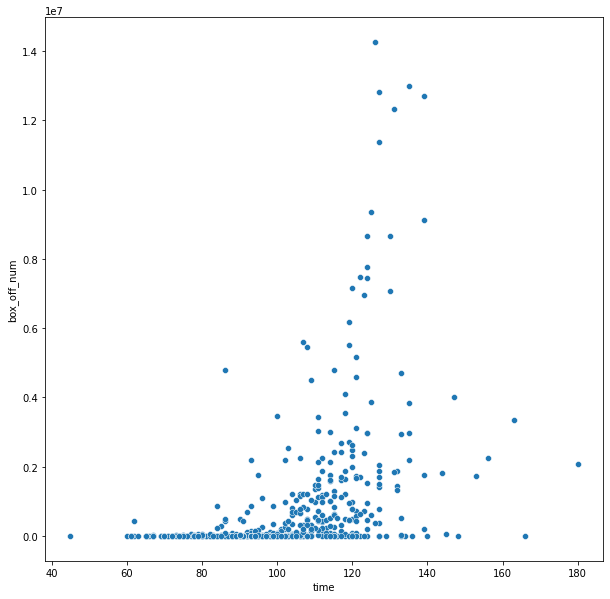

In [6]:
plt.figure(figsize=[10,10])
sns.scatterplot(data=train, x='time', y = 'box_off_num')

- 상영시간과 관객 수 그래프   
  120~140분 사이에 관객 수가 많음

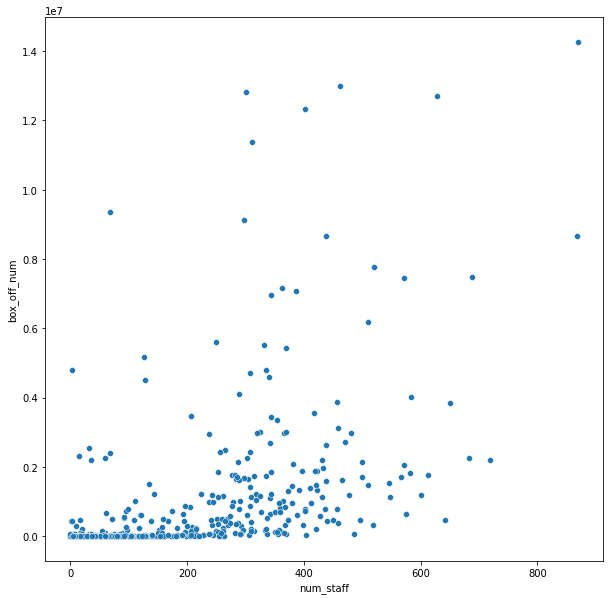

In [7]:
plt.figure(figsize=[10,10])
sns.scatterplot(data=train, x='num_staff', y = 'box_off_num')

- 스태프 수와 관객 수 그래프   
스태프 수가 많으면 관객 수가 많음

In [8]:
pd.options.display.float_format = '{:.1f}'.format # 이 코드 실행 후 describe()실행하면 지수형식으로 출력된 것을 바꿔줌

In [9]:
train.groupby('genre').box_off_num.mean().sort_values()

genre
뮤지컬         6627.0
다큐멘터리      67172.3
서스펜스       82611.0
애니메이션     181926.7
멜로/로맨스    425968.0
미스터리      527548.2
공포        590832.5
드라마       625689.8
코미디      1193914.0
SF       1788345.7
액션       2203974.1
느와르      2263695.1
Name: box_off_num, dtype: float64

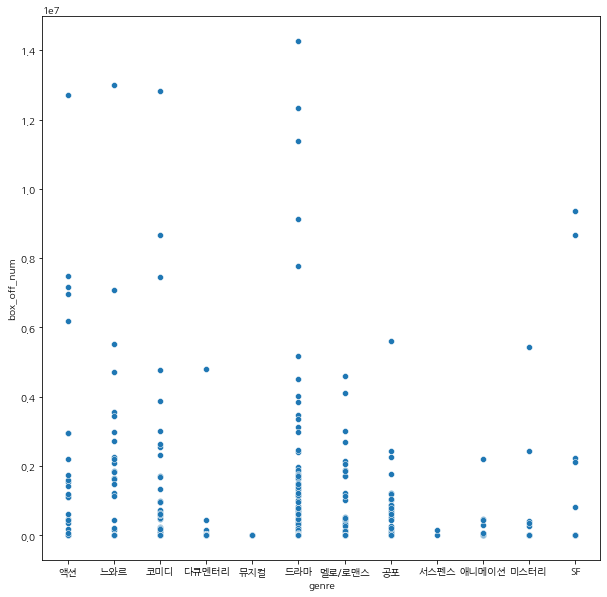

In [10]:
plt.rc("font", family="NanumGothic")
plt.figure(figsize=[10,10])
sns.scatterplot(data=train, x='genre', y = 'box_off_num')

장르와 관객 수의 그래프

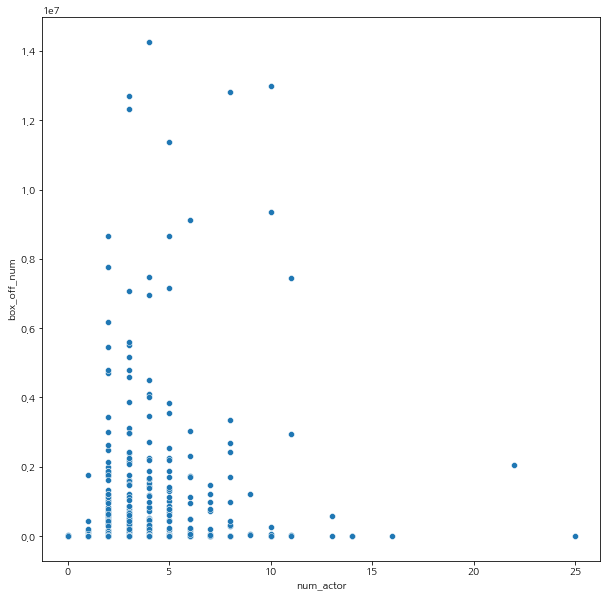

In [11]:
plt.figure(figsize=[10,10])
sns.scatterplot(data=train, x='num_actor', y = 'box_off_num')

주연 배우 수와 관객 수의 그래프

In [12]:
test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,300529.0,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,342700.2,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4206610.7,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,691342.0,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,31738.0,1,380,1


In [13]:
submission.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


#### pd.데이터프레임.tail()
- 데이터 프레임의 아래에서부터 n개 행을 보여주는 함수
- n의 기본 값(default 값)은 5

In [9]:
train.tail()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.0,1,510,7,1475091
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.0,1,286,6,1716438
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525
599,베를린,CJ 엔터테인먼트,액션,2013-01-30,120,15세 관람가,류승완,NaN,0,363,5,7166532


#### pd.데이터프레임.shape()
- 데이터 프레임의 행의 개수와 열의 개수가 저장되어 있는 속성(attribute)

In [14]:
print(train.shape)
print(test.shape)
print(submission.shape)

(600, 12)
(243, 11)
(243, 2)


#### pd.데이터프레임.info()
- 데이터셋의 column별 정보를 알려주는 함수
- 비어 있지 않은 값은(non-null)은 몇개 인지?
- column의 type은 무엇인지?
  * type의 종류 : int(정수), float(실수), object(문자열), 등등(date) ...

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


dir_prev_bfnum 가 결측값이 330개 존재

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


dir_prev_bfnum 가 107개만 채워져있음

#### pd.데이터프레임.describe()
- 숫자형 (int, float) column들의 기술 통계량을 보여주는 함수
- 기술통계량이란?
  *해당 column을 대표할 수 있는 통계값들을 의미
- 기술통계량 종류
  * count: 해당 column에서 비어 있지 않은 값의 개수
  * mean: 평균
  * std: 표준편차
  * min: 최솟값 (이상치 포함)
  * 25% (Q1): 전체 데이터를 순서대로 정렬했을 때, 아래에서 부터 1/4번째 지점에 있는 값
  * 50% (Q2): 중앙값 (전체 데이터를 순서대로 정렬했을 때, 아래에서 부터 2/4번째 지점에 있는 값)
  * 75% (Q3): 전체 데이터를 순서대로 정렬했을 때, 아래에서 부터 3/4번째 지점에 있는 값
  * max: 최댓값 (이상치 포함)
- 이상치: 울타리 밖에 있는 부분을 이상치라고 정의함
  * 아래쪽 울타리: Q_1Q1​ - 1.5 * IQR1.5∗IQR
  * 위쪽 울타리: Q_3Q3​ + 1.5 * IQR1.5∗IQR
  * IQRIQR = Q_3 - Q_1Q3​−Q1​
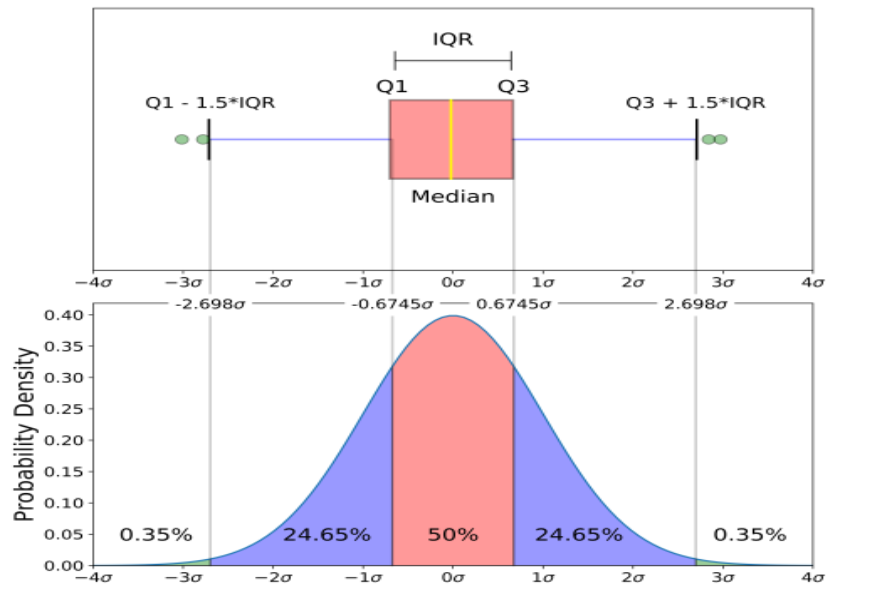

In [17]:
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.0,270.0,600.0,600.0,600.0,600.0
mean,100.9,1050442.9,0.9,151.1,3.7,708181.8
std,18.1,1791408.3,1.2,165.7,2.4,1828005.9
min,45.0,1.0,0.0,0.0,0.0,1.0
25%,89.0,20380.0,0.0,17.0,2.0,1297.2
50%,100.0,478423.6,0.0,82.5,3.0,12591.0
75%,114.0,1286568.6,2.0,264.0,4.0,479886.8
max,180.0,17615314.0,5.0,869.0,25.0,14262766.0


In [18]:
test.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,243.0,107.0,243.0,243.0,243.0
mean,109.8,891669.5,0.9,159.3,3.5
std,124.0,1217341.5,1.2,163.0,2.1
min,40.0,34.0,0.0,0.0,0.0
25%,91.0,62502.0,0.0,18.0,2.0
50%,104.0,493120.0,0.0,105.0,3.0
75%,114.5,1080849.6,1.0,282.0,4.0
max,2015.0,6173099.5,6.0,776.0,16.0


In [ ]:
pd.options.display.float_format = '{:.1f}'.format # 이 코드 실행 후 describe()실행하면 지수형식으로 출력된 것을 바꿔줌

#### pd.데이터프레임.groupby()
- 집단에 대한 통계량 확인

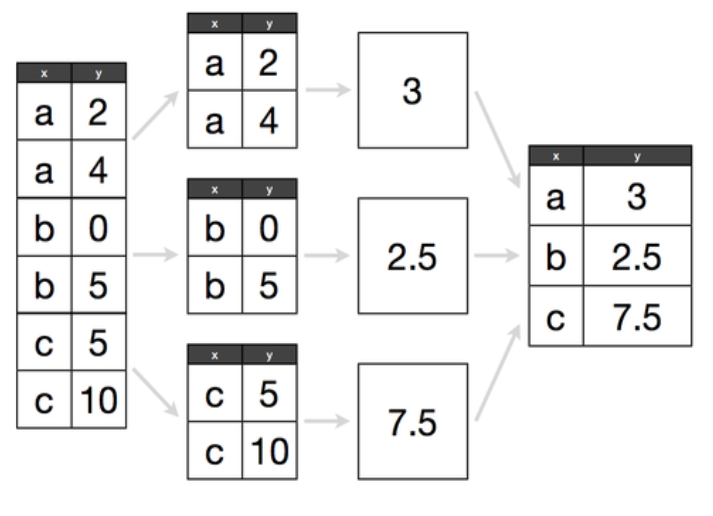 

In [19]:
# 장르별 관객 수 평균으로 정렬
train[['genre', 'box_off_num']].groupby('genre').mean().sort_values('box_off_num')

,box_off_num
genre,
뮤지컬,6627.0
다큐멘터리,67172.3
서스펜스,82611.0
애니메이션,181926.7
멜로/로맨스,425968.0
미스터리,527548.2
공포,590832.5
드라마,625689.8
코미디,1193914.0


genre, box_off_num을 genre로 그룹화한 후 평균을 산출해서 sort_values로 정렬   
위 관객 수로만 보면 액션, 느와르가 가장 인기가 좋은 것으로 볼 수 있음

- 상관계수: 두 개의 변수가 같이 일어나는 강도를 나타내는 수치
- -1에서 1사이의 값을 지닙니다.
- -1이나 1인 수치는 현실 세계에서 관측되기 힘든 수치입니다.
- 분야별로 기준을 정하는 것에 따라 달라지겠지만, 보통 0.4이상이면 두 개의 변수간에 상관성이 있다고 얘기합니다.

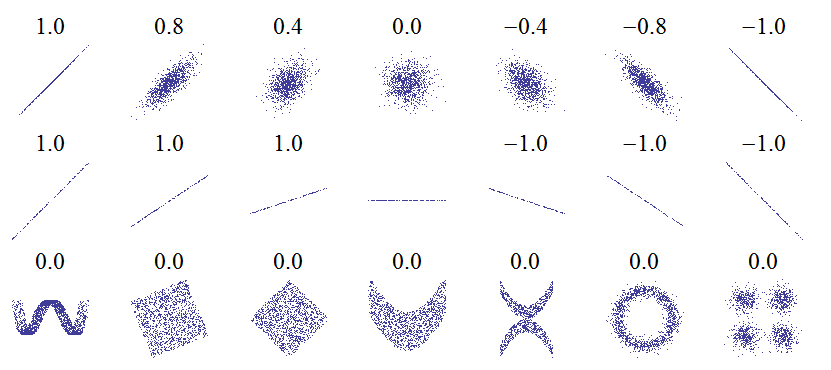


- 상관관계와 인과관계는 다릅니다.


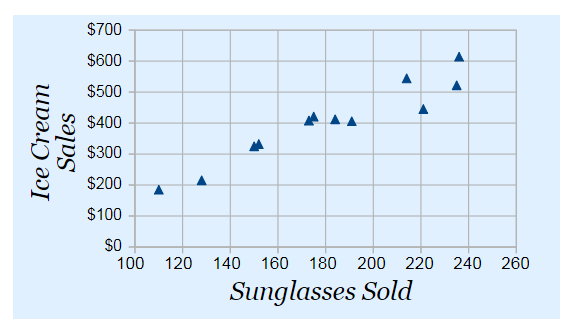


- 선글라스 판매량이 증가함에 따라, 아이스크림 판매액도 같이 증가하는 것을 볼 수 있습니다.
- 하지만 선글라스 판매량이 증가했기 때문에 아이스크림 판매액이 증가했다라고 해석하는 것은 타당하지 않습니다.
- 선글라스 판매량이 증가했다는 것은 여름 때문이라고 볼 수 있으므로, 날씨가 더워짐에 따라 선글라스 판매량과 아이스크림 판매액이 같이 증가했다고 보는 것이 타당할 것입니다.

#### pd.데이터프레임.corr()
- correlation coefficient 의 줄임말 입니다

In [21]:
pd.reset_option('display.float_format') # 지수형식으로 변경

In [22]:
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000


위 상관계수를 보면 숫자형태로 보는 것은 직관적이지 않기 때문에 시각적으로 보겠다.

In [23]:
import seaborn as sns

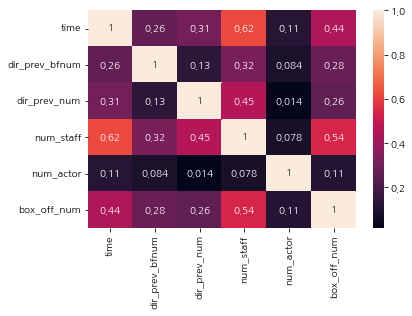

In [24]:
sns.heatmap(train.corr(), annot = True)

- num_staff 스태프 수가 많은 수록 관객 수가 많음
- time 영화 상영 시간이 길수록 관객수가 많음

## 3. 데이터 전처리
### Data Cleansing & Pre-Processing
#### pd.Series.isna()
- 결측치 여부를 확인해줍니다.
- 결측치면 True, 아니면 False

In [25]:
train.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [26]:
# 결측값이 있는 행만 출력
train[train['dir_prev_bfnum'].isna()]

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
6,길위에서,백두대간,다큐멘터리,2013-05-23,104,전체 관람가,이창재,NaN,0,32,5,53526
8,"1789, 바스티유의 연인들",유니버설픽쳐스인터내셔널코리아,뮤지컬,2014-09-18,129,전체 관람가,정성복,NaN,0,3,5,4778
9,청춘그루브,(주)두타연,드라마,2012-03-15,94,15세 관람가,변성현,NaN,0,138,3,868
10,AV 아이돌,(주) 케이알씨지,멜로/로맨스,2015-07-27,89,청소년 관람불가,조조 히데오,NaN,0,0,4,745
...,...,...,...,...,...,...,...,...,...,...,...,...
593,낭만파 남편의 편지,퍼스트런,미스터리,2013-09-12,97,청소년 관람불가,최위안,NaN,0,5,3,1132
594,오빠가 돌아왔다,(주)마운틴픽쳐스,코미디,2014-03-20,94,청소년 관람불가,노진수,NaN,0,37,5,1958
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525


In [27]:
# 결측값이 있는 행의 'dir_prev_num'이 모두 0인지 확인
train[train['dir_prev_bfnum'].isna()]['dir_prev_num'].sum()

0

In [28]:
test.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

In [29]:
test[test['dir_prev_bfnum'].isna()]

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
5,회오리 바람,모쿠슈라,드라마,2010-02-25,95,15세 관람가,장건재,NaN,0,156,2
6,경계도시 2,시네마 달,다큐멘터리,2010-03-18,104,15세 관람가,홍형숙,NaN,0,11,2
7,이웃집 남자,(주)루믹스미디어,드라마,2010-03-18,100,청소년 관람불가,장동홍,NaN,0,117,5
8,아마존의 눈물 극장판,마운틴픽쳐스,다큐멘터리,2010-03-25,88,15세 관람가,김진만,NaN,0,76,1
9,반가운 살인자,롯데쇼핑(주)롯데엔터테인먼트,코미디,2010-04-08,107,15세 관람가,김동욱,NaN,0,255,3
...,...,...,...,...,...,...,...,...,...,...,...
235,타이밍,(주)스톰픽쳐스코리아,애니메이션,2015-12-10,100,15세 관람가,민경조,NaN,0,56,1
237,어떤이의 꿈,하준사,드라마,2015-11-26,72,12세 관람가,조성규,NaN,0,29,3
239,울보 권투부,인디스토리,다큐멘터리,2015-10-29,86,12세 관람가,이일하,NaN,0,18,2
240,어떤살인,(주)컨텐츠온미디어,느와르,2015-10-28,107,청소년 관람불가,안용훈,NaN,0,224,4


In [30]:
# 결측값이 있는 행의 'dir_prev_num'이 모두 0인지 확인
test[test['dir_prev_bfnum'].isna()]['dir_prev_num'].sum()

0

#### pd.DataFrame.fillna()
- 결측치를 채우고자 하는 column과 결측치를 대신하여 넣고자 하는 값을 명시
- 범주형 변수일 경우, 최빈값으로 대체할 수 있음

In [31]:
# 결측값을 0으로 채우기. inplace = True로 설정시 저장까지 완료
train['dir_prev_bfnum'].fillna(0, inplace=True)

In [32]:
train.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
dtype: int64

In [33]:
# 결측값을 0으로 채우기. inplace = True로 설정시 저장까지 완료
test['dir_prev_bfnum'].fillna(0, inplace=True)

In [34]:
test.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
dtype: int64

## 4. 변수 선택 및 모델 구축
### Feature Engineering & Initial Modeling
- X (상영 시간, 영화 제작에 참여한 스태프 수, 배우 수 ...) -> MODEL -> y (영화 관객 수)

In [35]:
# 영화 관객 수는 연속된 값 : Regressor
# random_state = 777은 어느 pc에서도 결과값이 같게 나오게 고정시켜줌
# n_estimators : 순차적으로 1000개의 모델을 만들겠다
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

In [36]:
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor']
target = ['box_off_num']

In [37]:
X_train, X_test, y_train = train[features], test[features], train[target]

## 5. 모델 학습 및 검증
### Model Tuning & Evaluation
a. ligtGBM (base model)
b. k-fold lightGBM (k-fold model)
c. feature engineering (fe)
d. grid search (hyperparameter tuning)

### LightGBM
- 부스팅 모델
- 기존 모델이 못 맞춘 문제에 가중치를 두어 지속적으로 학습 이어나감
- 타 부스팅 모델에 비해 속도가 빠름

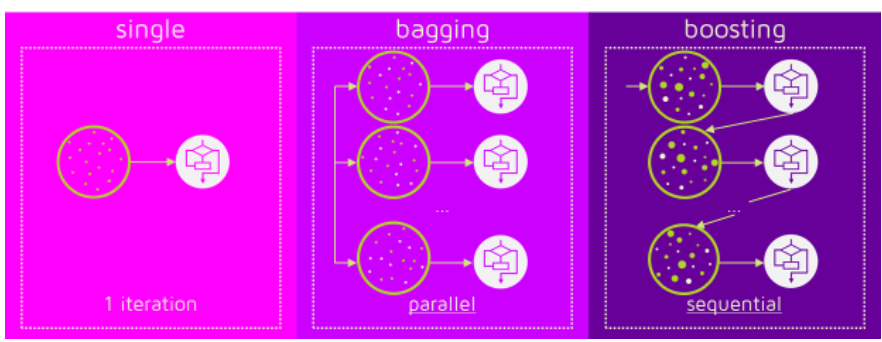

In [38]:
model.fit(X_train, y_train)

LGBMRegressor(n_estimators=1000, random_state=777)

In [39]:
# 답안지 복사
singleLGBM = submission.copy()

In [40]:
singleLGBM['box_off_num'] = model.predict(X_test)

In [41]:
singleLGBM.head()

,title,box_off_num
0,용서는 없다,2.817995e+06
1,아빠가 여자를 좋아해,3.753772e+05
2,하모니,-5.693243e+05
3,의형제,1.581189e+06
4,평행 이론,-5.277806e+05


관객 수가 음수가 나올 수는 없으므로 성능이 안 좋은 모델임을 확인

In [ ]:
singleLGBM.to_csv('singleLGBM.csv', index = False)

### k-fold 교차검증 (k-fold cross validation)
- 과대적합 방지
- 모델 간 일반적인 성능 비교
- validation set, development set

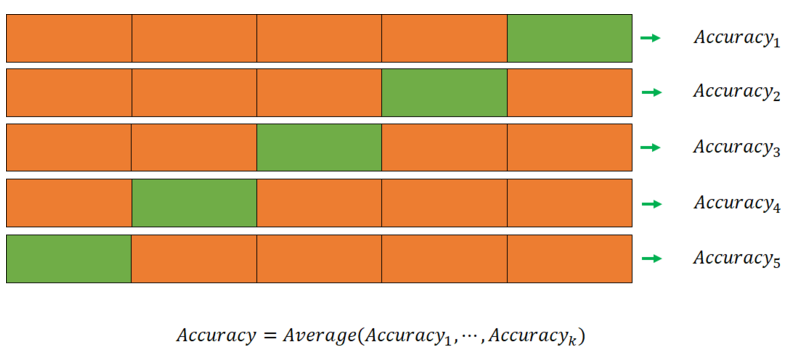


In [42]:
from sklearn.model_selection import KFold

In [43]:
# n_splits = 5 는 몇등분을 할지 설정
# shuffle = True는 섞어서 5등분 시킨다. 섞는 이유는 순서에 대한 영향력이 있을 수 있기에 섞어줌
# 시계열같은 시간 속성이 중요한거 외엔 거의 shuffle 해줌
k_fold = KFold(n_splits= 5, shuffle = True, random_state = 777)

In [44]:
model = lgb.LGBMRegressor(random_state= 777, n_estimators= 1000)

# 모델 5개 담을 바구니
models = []

for train_idx, val_idx in k_fold.split(X_train):
  x_t = X_train.iloc[train_idx]
  y_t = y_train.iloc[train_idx]
  x_val = X_train.iloc[val_idx]
  y_val = y_train.iloc[val_idx]
  # early_stopping_rounds: 부스팅 모델이 순차적으로 반복하는 것을 일정횟수가 되면 끊어주기(과적합 방지).
  # early_stopping_rounds = 100 은 100번의 과정동안 오차율이 감소되지 않으면 멈춰라
  # verbose = 100 은 100번째 모델마다 성능 출력해줘
  models.append(model.fit(x_t, y_t, eval_set = (x_val, y_val), early_stopping_rounds = 100, verbose = 100))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.70572e+12
Early stopping, best iteration is:
[6]	valid_0's l2: 2.45438e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 3.90847e+12
Early stopping, best iteration is:
[33]	valid_0's l2: 3.72825e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 3.50344e+12
Early stopping, best iteration is:
[8]	valid_0's l2: 2.58737e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.45977e+12
Early stopping, best iteration is:
[11]	valid_0's l2: 1.26226e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.77214e+12
Early stopping, best iteration is:
[22]	valid_0's l2: 1.57631e+12


In [45]:
models

[LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777)]

In [46]:
preds =[]
for model in models:
  preds.append(model.predict(X_test))
len(preds)

5

In [47]:
kfoldLightGBM = submission.copy() # 답안지 복사

In [48]:
import numpy as np # 예측값의 평균을 구하기 위해 numpy 임포트

In [49]:
# 예측값들이 5세트가 입력되어 있음
# 축을 0으로 두고 이것들의 평균을 내기
kfoldLightGBM['box_off_num'] = np.mean(preds, axis =0)

In [50]:
kfoldLightGBM.head()

,title,box_off_num
0,용서는 없다,3.367422e+06
1,아빠가 여자를 좋아해,9.611389e+05
2,하모니,1.097930e+06
3,의형제,2.097271e+06
4,평행 이론,7.814763e+05


In [ ]:
kfoldLightGBM.to_csv('kfoldLightGBM.csv', index = False)

### feature engineering

In [51]:
features

['time', 'dir_prev_num', 'num_staff', 'num_actor']

genre와 dir_prev_bfnum을 포함해서 활용해보자   
genre 데이터는 글자로 되어있으니 숫자로 변환하여 사용

In [ ]:
train.columns

Index(['title', 'distributor', 'genre', 'release_time', 'time',
       'screening_rat', 'director', 'dir_prev_bfnum', 'dir_prev_num',
       'num_staff', 'num_actor', 'box_off_num'],
      dtype='object')

In [52]:
train.genre

0       액션
1      느와르
2       액션
3      코미디
4      코미디
      ... 
595    드라마
596    드라마
597     공포
598    느와르
599     액션
Name: genre, Length: 600, dtype: object

In [53]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train['genre'] = le.fit_transform(train['genre']) # 값들을 다 숫자로 바꿔줌

In [54]:
train['genre']

0      10
1       2
2      10
3      11
4      11
       ..
595     4
596     4
597     1
598     2
599    10
Name: genre, Length: 600, dtype: int64

In [55]:
test['genre'] = le.transform(test['genre']) # train에서 학습한 숫자와 동일하게 장르 변경됨

train은 fit_transform인데 test셋은 transform으로만 변환함   
test셋에 또 fit(훈련하다)을 넣어주면 결과 값이 달라질 수 있으니 transform만 해야된다

In [56]:
features =['time', 'dir_prev_num', 'num_staff', 'num_actor', 'dir_prev_bfnum', 'genre']

In [57]:
X_train, X_test, y_train = train[features], test[features], train[target]

In [58]:
model = lgb.LGBMRegressor(random_state= 777, n_estimators= 1000)

# 모델 5개 담을 바구니
models = []

for train_idx, val_idx in k_fold.split(X_train):
  x_t = X_train.iloc[train_idx]
  y_t = y_train.iloc[train_idx]
  x_val = X_train.iloc[val_idx]
  y_val = y_train.iloc[val_idx]
  
  models.append(model.fit(x_t, y_t, eval_set = (x_val, y_val), early_stopping_rounds = 100, verbose = 100))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.62067e+12
Early stopping, best iteration is:
[9]	valid_0's l2: 2.42668e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 4.39227e+12
Early stopping, best iteration is:
[23]	valid_0's l2: 3.97173e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 3.29841e+12
Early stopping, best iteration is:
[10]	valid_0's l2: 2.53643e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.56499e+12
Early stopping, best iteration is:
[16]	valid_0's l2: 1.21201e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.60118e+12
Early stopping, best iteration is:
[29]	valid_0's l2: 1.47528e+12


In [59]:
preds =[]
for model in models:
  preds.append(model.predict(X_test))
len(preds)

5

In [60]:
feLightGBM = submission.copy()

In [61]:
feLightGBM['box_off_num'] = np.mean(preds, axis = 0)

In [62]:
feLightGBM.to_csv('feLightGBM.csv', index = False)

### Grid Search
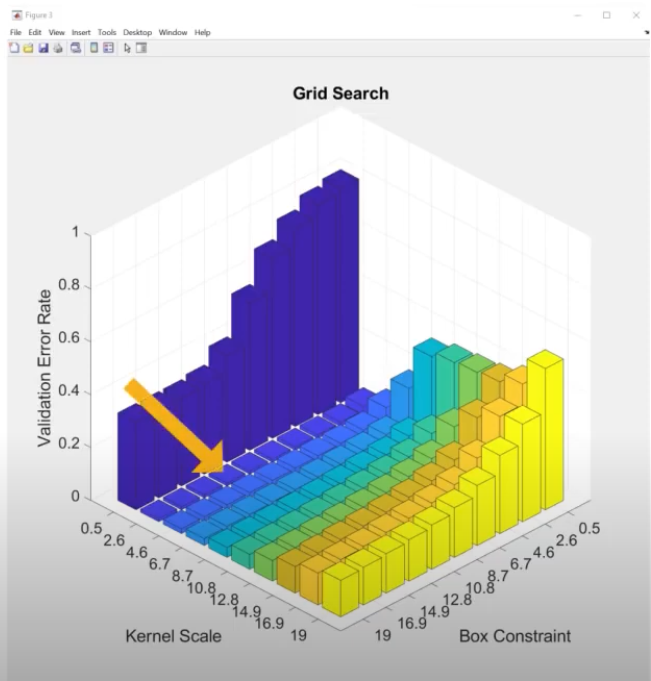

In [63]:
from sklearn.model_selection import GridSearchCV

In [64]:
from re import M
model = lgb.LGBMRegressor(random_state= 777, n_estimators=1000)

# 6개 조합의 파라미터
# learning_rate: 모델링을 하는 간격. 순차적으로 진행할 때 기존 모델에 대한 성능을 얼마나 다음 모델에 반영할 것인지. 값이 적을 수록 미세하게 변화
params ={
    'learning_rate': [0.1, 0.01, 0.003],
    'min_child_samples':[20,30]}

# scoring 을 rmse로 한 이유는 현재 이 대회의 평가지표가 rmse값이기 때문
gs = GridSearchCV(estimator=model,
                  param_grid = params,
                  scoring = 'neg_mean_squared_error',
                  cv = k_fold) # cv = 5 해도 같음

In [65]:
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=777, shuffle=True),
             estimator=LGBMRegressor(n_estimators=1000, random_state=777),
             param_grid={'learning_rate': [0.1, 0.01, 0.003],
                         'min_child_samples': [20, 30]},
             scoring='neg_mean_squared_error')

In [66]:
# 가장 좋은 파라미터 조합
gs.best_params_

{'learning_rate': 0.003, 'min_child_samples': 30}

In [67]:
model = lgb.LGBMRegressor(random_state= 777, n_estimators=1000, learning_rate = 0.003, min_child_samples=30)

models = []

for train_idx, val_idx in k_fold.split(X_train):
  x_t = X_train.iloc[train_idx]
  y_t = y_train.iloc[train_idx]
  x_val = X_train.iloc[val_idx]
  y_val = y_train.iloc[val_idx]
  
  models.append(model.fit(x_t, y_t, eval_set = (x_val, y_val), early_stopping_rounds = 100, verbose = 100))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.56673e+12
[200]	valid_0's l2: 2.45583e+12
[300]	valid_0's l2: 2.42575e+12
[400]	valid_0's l2: 2.43392e+12
Early stopping, best iteration is:
[335]	valid_0's l2: 2.42348e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 4.89194e+12
[200]	valid_0's l2: 4.40922e+12
[300]	valid_0's l2: 4.19146e+12
[400]	valid_0's l2: 4.05951e+12
[500]	valid_0's l2: 3.96931e+12
[600]	valid_0's l2: 3.91727e+12
[700]	valid_0's l2: 3.88462e+12
[800]	valid_0's l2: 3.87695e+12
[900]	valid_0's l2: 3.87088e+12
Early stopping, best iteration is:
[876]	valid_0's l2: 3.87035e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 3.14361e+12
[200]	valid_0's l2: 2.79286e+12
[300]	valid_0's l2: 2.59302e+12
[400]	valid_0's l2: 2.47608e+12
[500]	valid_0's l2: 2.40386e+12
[600]	valid_0's l2: 2.36407e+12
[700]	valid_0's l2: 2.38505e+12
Early stopping, best iteration is:
[6

In [68]:
preds =[]
for model in models:
  preds.append(model.predict(X_test))

In [69]:
gs.best_score_

-2334525343085.6494

In [70]:
gslgbm = submission.copy()

In [71]:
gslgbm['box_off_num'] = np.mean(preds, axis = 0)

In [ ]:
gslgbm.to_csv('gslgbm.csv', index = False)

#### 데이콘 평가지표는 RMSE로 한다고한다.
##### 평균 제곱근 편차(RMSE)이란?
RMSE란 Root Mean Square Error의 약자로 인공지능 예측 모델의 정확도를 측정하기 위해 사용되는 대표적인 지표 중 하나입니다. RMSE를 계산하기 위해서는 우선 예측값과 실제값의 차이, 즉 오차를 구해야 합니다. 그 후, 모든 오차들의 제곱의 평균값을 구하고, 평균값의 제곱근을 구하면 RMSE 값을 찾을 수 있습니다. RMSE 공식은 아래와 같은 모습으로, 표준편차의 공식과 같습니다.